In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap

In [2]:
from dynchro.tl import dtw, traceback
from collections import defaultdict

In [3]:
# autorelad
%load_ext autoreload
%autoreload 2

# 1. Read in data

In [4]:
rep1_ery = ad.read_h5ad("../3_large_scale/data/rep1_ery_hvg.h5ad")
rep2_ery = ad.read_h5ad("../3_large_scale/data/rep2_ery_hvg.h5ad")
rep3_ery = ad.read_h5ad("../3_large_scale/data/rep3_ery_hvg.h5ad")

In [5]:
rep1_ery, rep2_ery, rep3_ery

(AnnData object with n_obs × n_vars = 2113 × 2082
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Ery'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Ery_pseudotime', 'pseudocells_100_Ery_pseudotime_index', 'pseudocells_100_Ery_pseudotime_values'
     obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'tsne'
     varm: 'pseudocells_100_Ery',
 AnnData object with n_obs × n_vars = 3203 × 2075
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Ery'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Ery_pseudotime', 'pseudocells_100_Ery_pseudotime_index', 'pseudocells_100_Ery_pseudotime_values'
     obsm: 'MAG

In [6]:
rep1_mono = ad.read_h5ad("../3_large_scale/data/rep1_mono_hvg.h5ad")
rep2_mono = ad.read_h5ad("../3_large_scale/data/rep2_mono_hvg.h5ad")
rep3_mono = ad.read_h5ad("../3_large_scale/data/rep3_mono_hvg.h5ad")
rep1_mono, rep2_mono, rep3_mono

(AnnData object with n_obs × n_vars = 3721 × 2082
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values'
     obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'tsne'
     varm: 'pseudocells_100_Mono',
 AnnData object with n_obs × n_vars = 3794 × 2075
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values'
     o

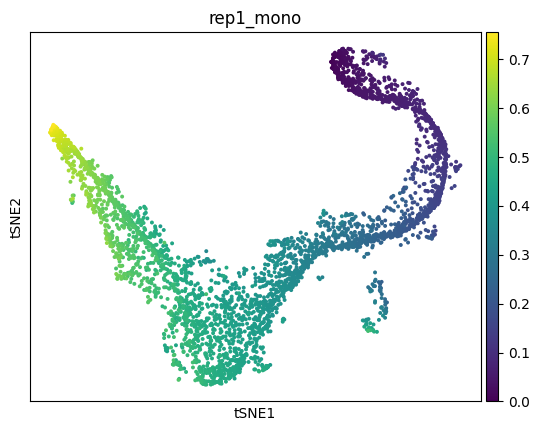

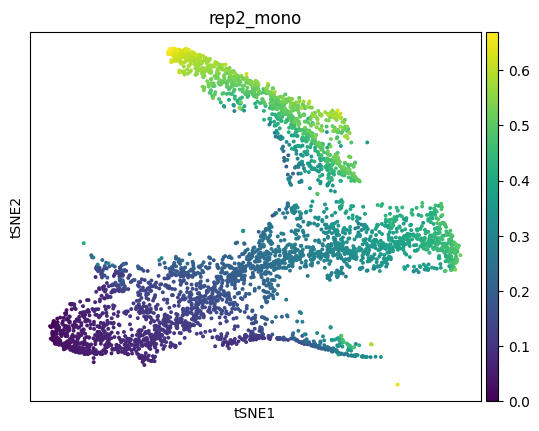

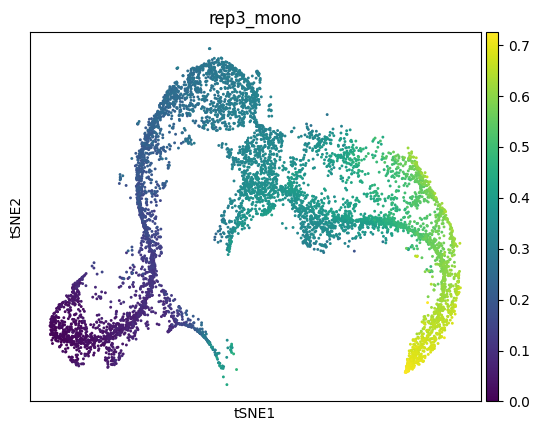

In [7]:
sc.pl.tsne(rep1_mono, color="pseudotime", title="rep1_mono")
sc.pl.tsne(rep2_mono, color="pseudotime", title="rep2_mono")
sc.pl.tsne(rep3_mono, color="pseudotime", title="rep3_mono")

# 2. Calculate pseudocells

In [8]:
# Generate pseudocells
def calculate_pseudocells(adata, amount: int):
    trunc_anndata = adata
    pseudocell_pseudotimes = interpolate_pseudocells(trunc_anndata, amount)
    trunc_anndata, pseudocells = smooth_pseudocells(trunc_anndata, pseudocell_pseudotimes, amount)

    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, pseudocell_pseudotimes)}

    # Save information into anndata
    adata.varm[f"pseudocells_{amount}"] = pseudocells.T
    adata.uns[f"pseudocells_{amount}_pseudotime"] = pd.Series(pseudocell_pseudotimes)
    if "pseudocells" not in adata.uns:
        adata.uns["pseudocells"] = []
    adata.uns["pseudocells"] += [f"pseudocells_{amount}"]
    return adata

def calc_pc(adata, amount, obsm_key=None):
    interpolated = interpolate_uniform(adata, amount)
    adata, pseudocells, transition_matrix = smooth_pseudocells(adata, interpolated, amount, obsm_key)
    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, interpolated)}

    return adata, pseudocells, pseudocell_pseudotimes, transition_matrix


def interpolate_pseudocells(adata, amount: int):
    # interpolate pseudotime based on the distribution of real cells in the pseudotime
    return np.percentile(sorted(adata.obs.pseudotime.values), np.linspace(0.0, 100, amount))

def interpolate_uniform(adata, amount: int):
    # interpolate pseudotime uniformly
    min_pseudotime = adata.obs.pseudotime.min()
    max_pseudotime = adata.obs.pseudotime.max()
    return np.linspace(min_pseudotime, max_pseudotime, amount)


def smooth_pseudocells(adata, pseudocell_pseudotimes, amount: int, obsm_key=None) -> np.ndarray:
    distances = calculate_pseudotime_distance(pseudocell_pseudotimes, sorted(adata.obs.pseudotime.values))
    adata.uns[f"transition_matrix_{amount}"] = np.array(
        [get_gaussian_transition_matrix(distances[i,], adata.X) for i in range(distances.shape[0])]
    )
    features = adata.X
    if obsm_key is not None:
        features = adata.obsm[obsm_key]
    return adata, np.array([apply_gaussian_kernel(distances[i,], features) for i in range(distances.shape[0])]), adata.uns[f"transition_matrix_{amount}"]

def calculate_pseudotime_distance(pseudocell_pseudotimes, trajectory_pseudotime: np.ndarray) -> np.ndarray:
    distances = []
    for cell in pseudocell_pseudotimes:
        distance = trajectory_pseudotime - cell
        distances.append(distance)
    return np.array(distances)

def apply_gaussian_kernel(x, counts):
    d = get_gaussian_transition_matrix(x, counts)
    
    # d = np.exp(-1 * (x**2) / (2**2))

    # FOR VISUALISATION PURPOSES
    # import matplotlib.pyplot as plt

    # plt.plot(x, color = "red")
    # plt.plot(d, color = "blue")
    # plt.figure()
    # plt.show()

    # d = d / sum(d)
    # plt.plot(d, color = "green")

    # plt.show()

    # @ = matrix multiplication (is transposition necessary or could the arguments be switched?)
    return counts.T @ d


def get_gaussian_transition_matrix(x, counts):
    d = np.exp(-1 * (x**2) / (0.005**2))
    return d / sum(d)


In [9]:
rep1_mono_, rep1_mono_pseudocells, rep1_mono_pseudotimes, rep1_trans = calc_pc(rep1_mono, 75)
# rep2_mono_, rep2_mono_pseudocells, rep2_mono_pseudotimes, rep2_trans = calc_pc(rep2_mono, 1000)
rep3_mono_, rep3_mono_pseudocells, rep3_mono_pseudotimes, rep3_trans = calc_pc(rep3_mono, 150)

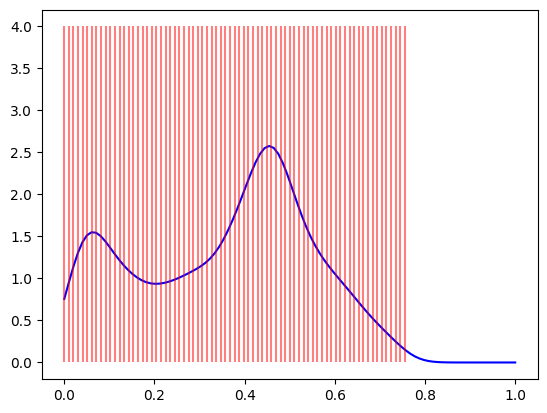

In [10]:
import scipy as sp
pseudotimes_kde_orig = sp.stats.gaussian_kde(rep1_mono.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(rep1_mono_pseudotimes.values(), 0, 4, color = "red", alpha=0.5)

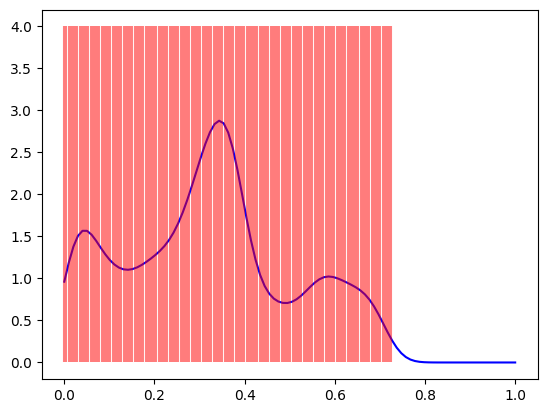

In [11]:
pseudotimes_kde_orig_3 = sp.stats.gaussian_kde(rep3_mono.obs["pseudotime"])
x_values3 = np.linspace(0, 1, 100)
y_values3 = pseudotimes_kde_orig_3(x_values3)
plt.plot(x_values3, y_values3, color = "blue")
plt.vlines(rep3_mono_pseudotimes.values(), 0, 4, color = "red", alpha=0.5)

In [12]:
d3 = ad.AnnData(X = rep1_mono_pseudocells, var = rep1_mono.var, obs = pd.DataFrame({"pseudotime": rep1_mono_pseudotimes}))
d4 = ad.AnnData(X = rep3_mono_pseudocells, var = rep3_mono.var, obs = pd.DataFrame({"pseudotime": rep3_mono_pseudotimes}))
d3, d4

(AnnData object with n_obs × n_vars = 75 × 2082
     obs: 'pseudotime',
 AnnData object with n_obs × n_vars = 150 × 2066
     obs: 'pseudotime')

In [13]:
common_vars = list(set.intersection(*(set(trajectory.var_names) for trajectory in [d3, d4])))
# select common vars
d3 = d3[:, common_vars]
d4 = d4[:, common_vars]
d3, d4

(View of AnnData object with n_obs × n_vars = 75 × 2048
     obs: 'pseudotime',
 View of AnnData object with n_obs × n_vars = 150 × 2048
     obs: 'pseudotime')

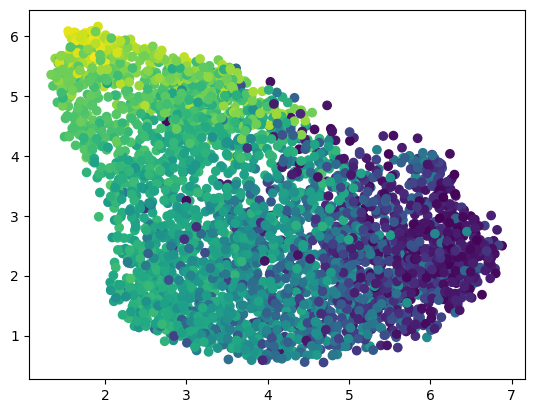

In [13]:
import umap

trans = umap.UMAP().fit(rep1_mono.X[:, :])
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c = rep1_mono.obs["pseudotime"])
plt.show()

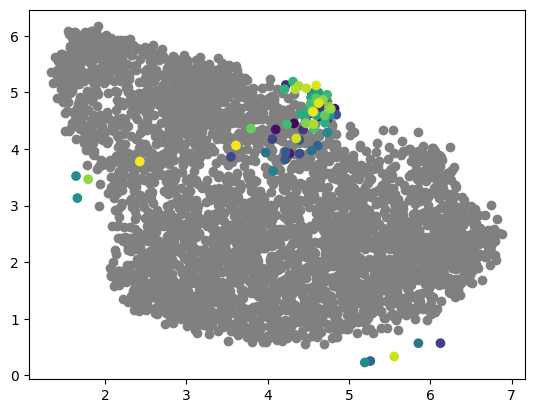

In [14]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c ="grey")

test_emb = trans.transform(d3.X[:,:])
plt.scatter(test_emb[:, 0], test_emb[:,1], c = d3.obs["pseudotime"])

In [29]:
import scipy.spatial

def dtw(x, y, distance="euclidean"):
    cost = scipy.spatial.distance.cdist(x, y, distance)
    tol = 1e-15
    cost[abs(cost) < tol] = 0

    r, c = len(x), len(y)

    distances = np.zeros((r + 1, c + 1))
    distances[0, 1:], distances[1:, 0] = np.inf, np.inf
    distances[0, 0] = 0

    for i in range(1, r + 1):
        for j in range(1, c + 1):
            options = [distances[i - 1, j - 1], distances[i - 1, j], distances[i, j - 1]]
            distances[i, j] = min(options) + cost[i - 1, j - 1]

    return distances[-1, -1], cost, distances[1:, 1:]


def traceback_start(D, i, j):
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = np.argmin((D[i - 1, j - 1], D[i, j - 1], D[i - 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            j -= 1
        elif tb == 2:
            i -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)


def traceback(D):
    i, j = np.array(D.shape) - 1

    return traceback_start(D, i, j)

In [31]:
total_p, cost_p, distances_p = dtw(d3.X, d4.X)
path1_p, path2_p = traceback(distances_p)

In [26]:
def flatten(l):
    # print(l)
    res = []
    for sublist in l:
        # print(sublist)
        for item in sublist:
            res.append(item)
    return res

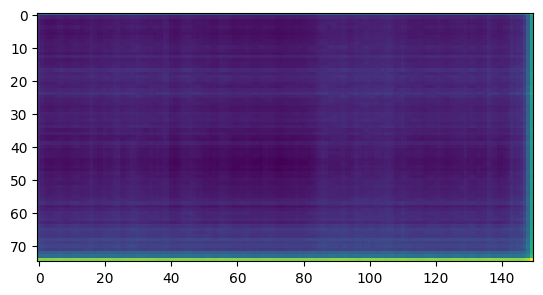

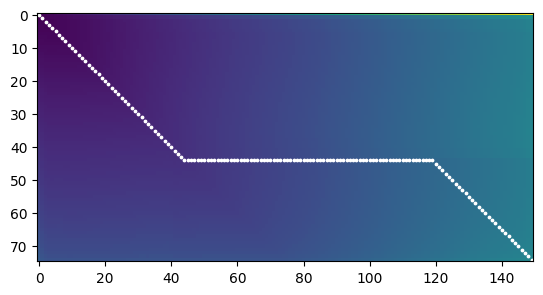

In [34]:
plt.imshow(cost_p)
plt.show()
plt.imshow(distances_p)
plt.scatter(path2_p, path1_p, c="white", s=3)



In [75]:
total_p, cost_p, distances_p = dtw(d3.X, d4.X)
path1_p, path2_p = traceback(distances_p)

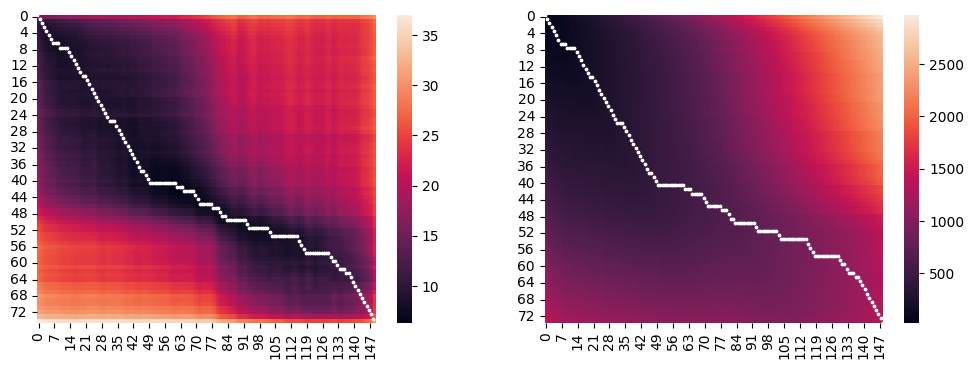

In [127]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.heatmap(cost_p, ax=ax1)
ax1.scatter(path2_p, path1_p, c="white", s=3)
distancesp = distances_p[1:, 1:]
sns.heatmap(distancesp, ax=ax2)
plt.scatter(path2_p, path1_p, c="white", s=3)
plt.show()

In [77]:
# sort according to pseudotime
rep1_mono = rep1_mono[rep1_mono.obs["pseudotime"].argsort()]
rep3_mono = rep3_mono[rep3_mono.obs["pseudotime"].argsort()]

common_vars = list(set.intersection(*(set(trajectory.var_names) for trajectory in [rep1_mono, rep3_mono])))
# select common vars
rep1_mono = rep1_mono[:, common_vars]
rep3_mono = rep3_mono[:, common_vars]

rep1_mono, rep3_mono

(View of AnnData object with n_obs × n_vars = 3721 × 2048
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono', 'avg_cost_free', 'avg_dist_free', 'pseudotime_warped'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values', 'transition_matrix_100', 'transition_matrix_75'
     obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'tsne'
     varm: 'pseudocells_100_Mono',
 View of AnnData object with n_obs × n_vars = 6934 × 2048
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono', 'avg_cost_free', 'avg_dist_free', 'pseudotime_warped'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels',

In [128]:
total, cost, distances = dtw(rep1_mono.X, rep3_mono.X)
path1, path2 = traceback(distances)

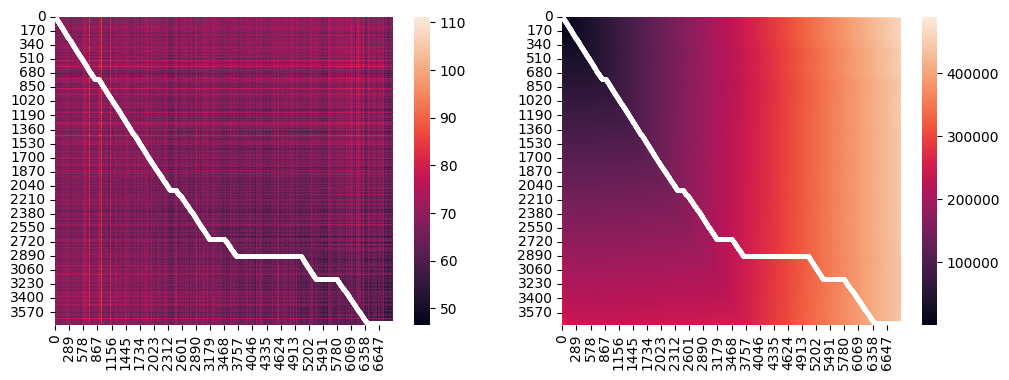

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.heatmap(cost, ax=ax1)
ax1.scatter(path2, path1, c="white", s=3)
distances = distances[1:, 1:]
sns.heatmap(distances, ax=ax2)
ax2.scatter(path2, path1, c="white", s=3)
plt.show()

In [80]:
# pathx must be the path that represents the x values of the path. 
#       it also indexes datasetx, so they must be the same length or less
# pathy must be the path that represents the y values of the path.
#       it also indexes datasety, so they must be the same length or less
def avg_cost_path(pathx, pathy, matrix, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index
    print(max(pathx), max(pathy), len(sorted_names1), len(sorted_names2), matrix.shape)

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_costx = defaultdict(list)
    avg_costy = defaultdict(list)

    for x, y in zip(pathx, pathy):
        # print(x, y)
        cost = matrix[y-1, x-1]

        avg_costx[sorted_names1[x-1]].append(cost)
        avg_costy[sorted_names2[y-1]].append(cost)

    acx = [sum(x) / len(x) for x in avg_costx.values()]
    acy = [sum(x) / len(x) for x in avg_costy.values()]

    costx = pd.Series(acx, index=list(avg_costx.keys()))
    costy = pd.Series(acy, index=list(avg_costy.keys()))

    return costx, costy

In [81]:
def avg_pseudotime_path(pathx, pathy, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_pseudotime1 = defaultdict(list)
    avg_pseudotime2 = defaultdict(list)

    for x, y in zip(pathx, pathy):
        ptx, pty = datasetx.obs["pseudotime"].values[x], datasety.obs["pseudotime"].values[y]
        avg_pseudotime1[sorted_names1[x]].append(ptx)
        avg_pseudotime2[sorted_names2[y]].append(pty)

    apx = [sum(x) / len(x) for x in avg_pseudotime1.values()]
    apy = [sum(x) / len(x) for x in avg_pseudotime2.values()]
    pseudotime_path1 = pd.Series(apx, index=list(avg_pseudotime1.keys()))
    pseudotime_path2 = pd.Series(apy, index=list(avg_pseudotime2.keys()))

    return pseudotime_path1, pseudotime_path2

In [82]:
costx, costy = avg_cost_path(pathx=path2, pathy=path1, matrix=cost, datasetx=rep3_mono, datasety=rep1_mono)
distx, disty = avg_cost_path(pathx=path2, pathy=path1, matrix=distances, datasetx=rep3_mono, datasety=rep1_mono)

6933 3720 6934 3721 (3721, 6934)
6933 3720 6934 3721 (3720, 6933)


In [83]:
rep3_mono.obs["avg_cost_free"] = costx
rep1_mono.obs["avg_cost_free"] = costy
rep3_mono.obs["avg_dist_free"] = distx
rep1_mono.obs["avg_dist_free"] = disty

/tmp/ipykernel_54897/3196506919.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rep3_mono.obs["avg_cost_free"] = costx
/tmp/ipykernel_54897/3196506919.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rep1_mono.obs["avg_cost_free"] = costy


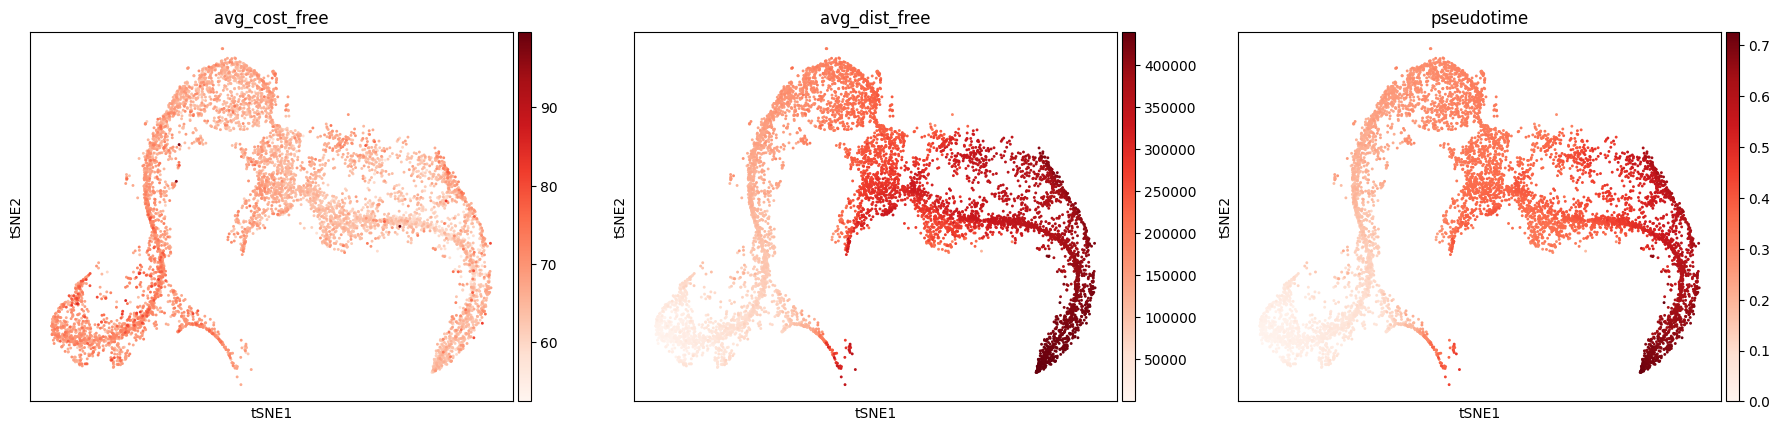

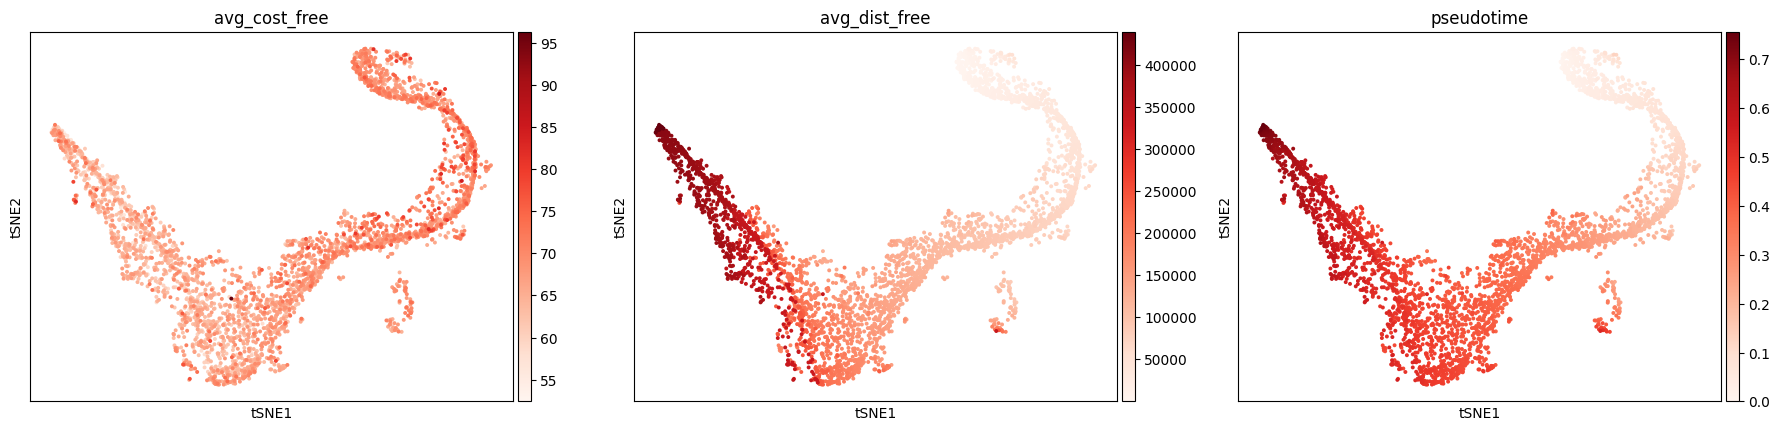

In [84]:
sc.pl.tsne(rep3_mono, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")
sc.pl.tsne(rep1_mono, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")

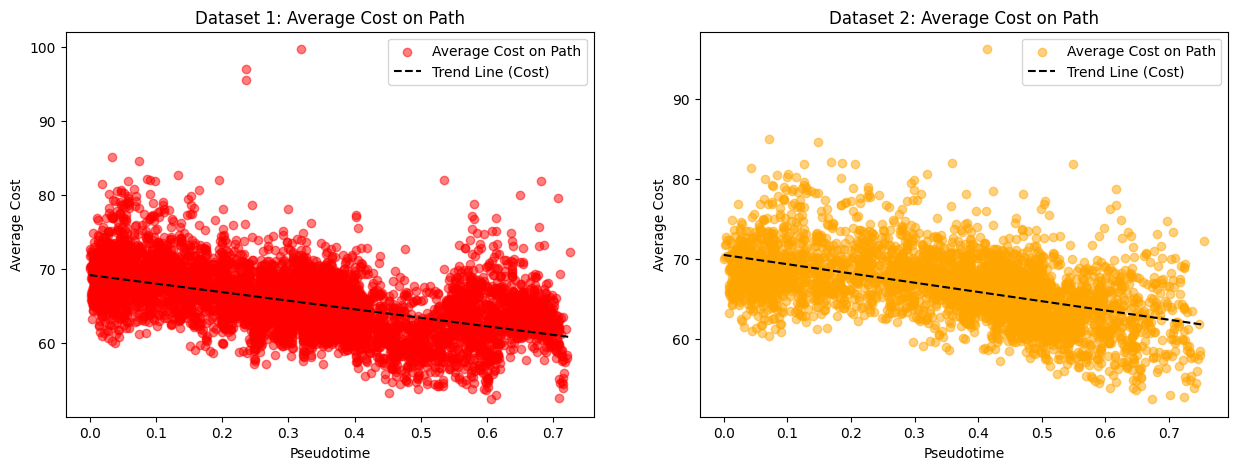

In [85]:
# plt.figure(figsize=(10, 5))
d1_avg_dist = rep3_mono.obs.sort_values("pseudotime")["avg_dist_free"].values
d1_avg_cost = rep3_mono.obs.sort_values("pseudotime")["avg_cost_free"].values
d2_avg_dist = rep1_mono.obs.sort_values("pseudotime")["avg_dist_free"].values
d2_avg_cost = rep1_mono.obs.sort_values("pseudotime")["avg_cost_free"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = rep3_mono.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = rep1_mono.obs.sort_values("pseudotime")["pseudotime"].values

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  

In [86]:
costx_p, costy_p = avg_cost_path(pathx=path2_p, pathy=path1_p, matrix=cost_p, datasetx=d4, datasety=d3)
distx_p, disty_p = avg_cost_path(pathx=path2_p, pathy=path1_p, matrix=distances_p, datasetx=d4, datasety=d3)

149 74 150 75 (75, 150)
149 74 150 75 (75, 150)


In [87]:
d4.obs["avg_cost_free"] = costx_p
d3.obs["avg_cost_free"] = costy_p
d4.obs["avg_dist_free"] = distx_p
d3.obs["avg_dist_free"] = disty_p

/tmp/ipykernel_54897/3179990982.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d4.obs["avg_cost_free"] = costx_p
/tmp/ipykernel_54897/3179990982.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d3.obs["avg_cost_free"] = costy_p


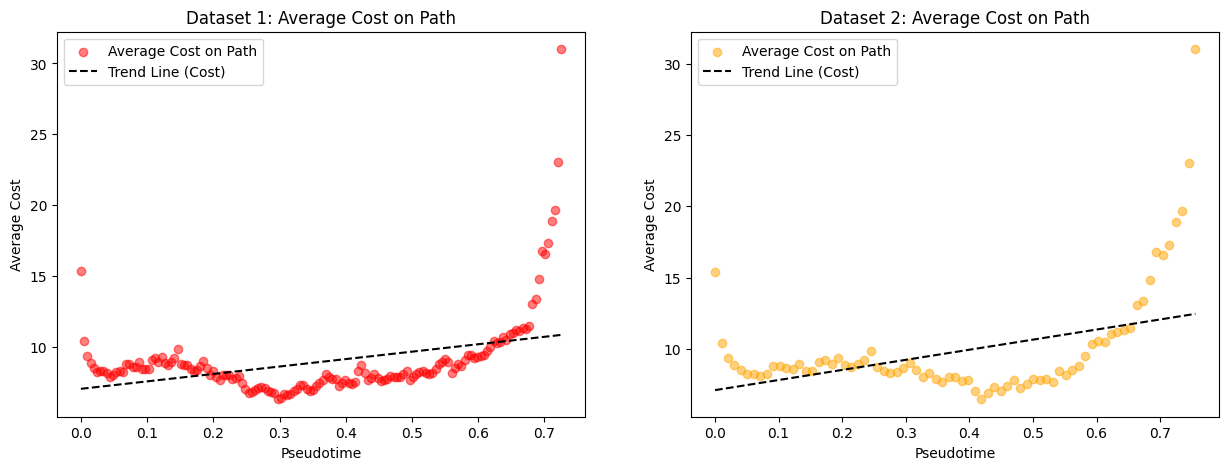

In [88]:
# plt.figure(figsize=(10, 5))
d1_avg_dist = d4.obs.sort_values("pseudotime")["avg_dist_free"].values
d1_avg_cost = d4.obs.sort_values("pseudotime")["avg_cost_free"].values
d2_avg_dist = d3.obs.sort_values("pseudotime")["avg_dist_free"].values
d2_avg_cost = d3.obs.sort_values("pseudotime")["avg_cost_free"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = d4.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = d3.obs.sort_values("pseudotime")["pseudotime"].values

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  

In [89]:
rep1_mono_pseudocells

array([[-0.15717186, -0.18681518, -1.14135   , ...,  0.09016299,
         0.20782991, -0.37326543],
       [-0.22550298, -0.02864154, -0.88854383, ..., -0.00760131,
        -0.07868653, -0.16215385],
       [ 0.09643594,  0.01824472, -0.57757752, ..., -0.11386482,
        -0.0510122 , -0.13822206],
       ...,
       [-0.66601562, -0.15611622, -0.28015029, ...,  0.60495015,
         0.14836642,  0.1103038 ],
       [-0.66601562, -0.35742483, -1.16303758, ...,  0.56636204,
        -0.10106666, -0.06777088],
       [-0.66601562, -0.36254283, -1.30158967, ..., -0.30169099,
        -0.12460832, -0.38854862]], shape=(75, 2048))

In [130]:
rep1_trans

array([[9.48630448e-02, 8.92052538e-02, 8.55453505e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.10759240e-03, 5.73964140e-03, 6.72440095e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.89999132e-06, 2.50309072e-05, 3.58268228e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.53109794e-03, 2.35547433e-03, 4.66286761e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.03573064e-01, 1.01600385e-01, 2.05951405e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.79318790e-01, 1.85418657e-01, 3.84873077e-01]], shape=(75, 3721))

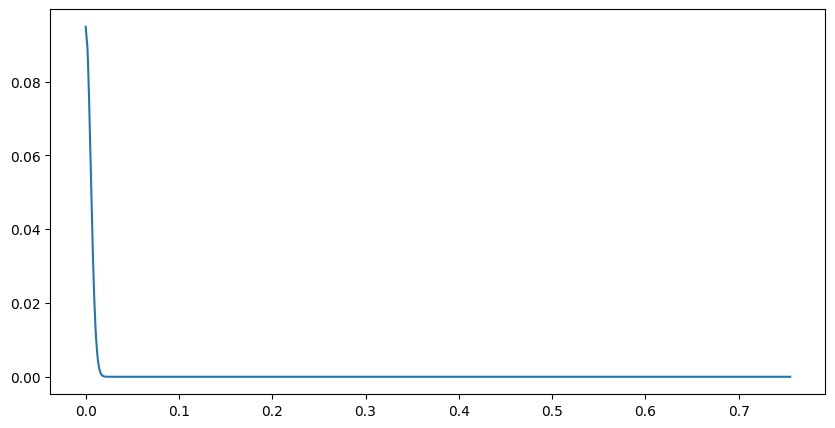

In [90]:
# set wide figsize
plt.figure(figsize=(10, 5))
plt.plot(rep1_mono.obs.pseudotime.values, rep1_trans[0,:])

In [91]:
contribution = rep1_trans[0,:][rep1_trans[0, :] >= 0.01]
sum(contribution), len(contribution)

(np.float64(0.8844287951900968), 22)

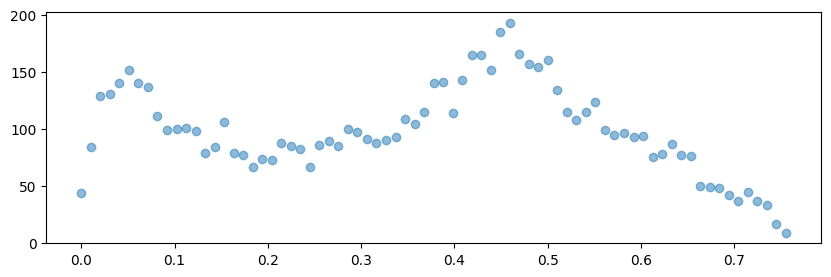

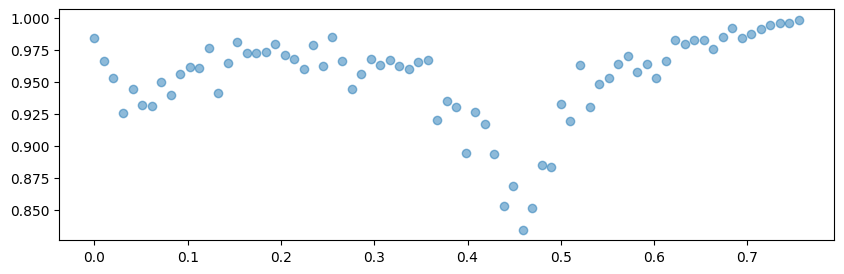

In [92]:
# get all contributions
contributions = []
contributing_cells = []
for i in range(rep1_trans.shape[0]):
    contributing_cells_part = rep1_trans[i,:] >= 0.002
    contributing_cells.append(contributing_cells_part)
    contribution = rep1_trans[i,:][rep1_trans[i, :] >= 0.002]
    contributions.append((sum(contribution), len(contribution)))
    # contributing_cells.extend([i] * len(contribution))

# plot amount covered and number of cells contributing
plt.figure(figsize=(10, 3))
plt.scatter(rep1_mono_pseudotimes.values(), [x[1] for x in contributions], alpha=0.5)
plt.show()
plt.figure(figsize=(10, 3))
plt.scatter(rep1_mono_pseudotimes.values(), [x[0] for x in contributions], alpha=0.5)

In [93]:
contributing_cells

[array([ True,  True,  True, ..., False, False, False], shape=(3721,)),
 array([ True,  True,  True, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3721,)),
 array([False, False, False, ..., False, False, False], shape=(3

In [94]:
wp1, wp2 = avg_pseudotime_path(pathx=path2, pathy=path1, datasetx=rep3_mono, datasety=rep1_mono)

In [95]:
wpp1, wpp2 = avg_pseudotime_path(pathx=path2_p, pathy=path1_p, datasetx=d4, datasety=d3)

In [96]:
len(wp1), len(wp2), len(rep3_mono.X), len(rep1_mono.X)
# Dus:
# wp1 met rep3_mono.X
# wp2 met rep1_mono.X
# en dan
# wpp1 met d4.X
# wpp2 met d3.X

(6934, 3721, 6934, 3721)

In [97]:
len(wpp1), len(wpp2), len(d4.X), len(d3.X)

(150, 75, 150, 75)

In [98]:
sorted_names1 = d4.obs["pseudotime"].sort_values().index # 150, d4
sorted_names2 = d3.obs["pseudotime"].sort_values().index # 100, d3
pt1 = defaultdict(list)
pt2 = defaultdict(list)

for x, y in zip(path2_p, path1_p): #path_2p indexes d4, path_1p indexes d3
    ptx = d4.obs["pseudotime"].values[x]
    pty = d3.obs["pseudotime"].values[y]
    print(f"x: {x}, y: {y}, ptx: {ptx}, pty: {pty}")
    pt1[sorted_names1[x]].append(pty)
    pt2[sorted_names2[y]].append(ptx)

avg_pt1 = [sum(x) / len(x) for x in pt1.values()]
avg_pt2 = [sum(x) / len(x) for x in pt2.values()]

wpp1 = pd.Series(avg_pt1, index=list(pt1.keys()))
wpp2 = pd.Series(avg_pt2, index=list(pt2.keys()))

x: 0, y: 0, ptx: 0.0, pty: 0.0
x: 1, y: 1, ptx: 0.004869432933541593, pty: 0.01020810603346482
x: 2, y: 2, ptx: 0.009738865867083186, pty: 0.02041621206692964
x: 3, y: 3, ptx: 0.014608298800624779, pty: 0.030624318100394458
x: 4, y: 4, ptx: 0.01947773173416637, pty: 0.04083242413385928
x: 5, y: 5, ptx: 0.024347164667707963, pty: 0.0510405301673241
x: 6, y: 6, ptx: 0.029216597601249557, pty: 0.061248636200788915
x: 7, y: 7, ptx: 0.03408603053479115, pty: 0.07145674223425373
x: 8, y: 7, ptx: 0.03895546346833274, pty: 0.07145674223425373
x: 9, y: 7, ptx: 0.043824896401874334, pty: 0.07145674223425373
x: 10, y: 8, ptx: 0.048694329335415926, pty: 0.08166484826771855
x: 11, y: 8, ptx: 0.053563762268957524, pty: 0.08166484826771855
x: 12, y: 8, ptx: 0.058433195202499115, pty: 0.08166484826771855
x: 13, y: 8, ptx: 0.0633026281360407, pty: 0.08166484826771855
x: 14, y: 9, ptx: 0.0681720610695823, pty: 0.09187295430118338
x: 15, y: 10, ptx: 0.07304149400312389, pty: 0.1020810603346482
x: 16, y: 

In [99]:
max(path2_p)

np.int64(149)

In [100]:
pt2

defaultdict(list,
            {'pseudocell_0': [np.float64(0.0)],
             'pseudocell_1': [np.float64(0.004869432933541593)],
             'pseudocell_2': [np.float64(0.009738865867083186)],
             'pseudocell_3': [np.float64(0.014608298800624779)],
             'pseudocell_4': [np.float64(0.01947773173416637)],
             'pseudocell_5': [np.float64(0.024347164667707963)],
             'pseudocell_6': [np.float64(0.029216597601249557)],
             'pseudocell_7': [np.float64(0.03408603053479115),
              np.float64(0.03895546346833274),
              np.float64(0.043824896401874334)],
             'pseudocell_8': [np.float64(0.048694329335415926),
              np.float64(0.053563762268957524),
              np.float64(0.058433195202499115),
              np.float64(0.0633026281360407)],
             'pseudocell_9': [np.float64(0.0681720610695823)],
             'pseudocell_10': [np.float64(0.07304149400312389)],
             'pseudocell_11': [np.float64(0.0779109

In [101]:
wpp1

pseudocell_0      0.000000
pseudocell_1      0.010208
pseudocell_2      0.020416
pseudocell_3      0.030624
pseudocell_4      0.040832
                    ...   
pseudocell_145    0.714567
pseudocell_146    0.724776
pseudocell_147    0.734984
pseudocell_148    0.745192
pseudocell_149    0.755400
Length: 150, dtype: float64

In [102]:
d4.obs["pseudotime_warped"] = wpp1
d3.obs["pseudotime_warped"] = wpp2
d4.obs, d3.obs

(                pseudotime  avg_cost_free  avg_dist_free  pseudotime_warped
 pseudocell_0      0.000000      15.390996      15.390996           0.000000
 pseudocell_1      0.004869      10.403703      25.794698           0.010208
 pseudocell_2      0.009739       9.359575      35.154274           0.020416
 pseudocell_3      0.014608       8.870755      44.025029           0.030624
 pseudocell_4      0.019478       8.520853      52.545882           0.040832
 ...                    ...            ...            ...                ...
 pseudocell_145    0.706068      17.310295    1253.241775           0.714567
 pseudocell_146    0.710937      18.867045    1272.108820           0.724776
 pseudocell_147    0.715807      19.646643    1291.755464           0.734984
 pseudocell_148    0.720676      23.054154    1314.809618           0.745192
 pseudocell_149    0.725546      31.002116    1345.811734           0.755400
 
 [150 rows x 4 columns],
                pseudotime  avg_cost_free  avg_di

In [103]:
(d4.obs["pseudotime_warped"] - d4.obs["pseudotime"]).values

array([ 0.        ,  0.00533867,  0.01067735,  0.01601602,  0.02135469,
        0.02669337,  0.03203204,  0.03737071,  0.03250128,  0.02763185,
        0.03297052,  0.02810109,  0.02323165,  0.01836222,  0.02370089,
        0.02903957,  0.03437824,  0.03971691,  0.04505559,  0.05039426,
        0.05573293,  0.0508635 ,  0.05620217,  0.06154085,  0.06687952,
        0.07221819,  0.07755686,  0.08289554,  0.08823421,  0.09357288,
        0.09891156,  0.10425023,  0.1095889 ,  0.10471947,  0.09985004,
        0.10518871,  0.11052738,  0.11586606,  0.12120473,  0.1265434 ,
        0.13188208,  0.13722075,  0.14255942,  0.1478981 ,  0.15323677,
        0.15857544,  0.16391411,  0.15904468,  0.16438335,  0.16972203,
        0.1750607 ,  0.17019127,  0.16532183,  0.1604524 ,  0.15558297,
        0.15071354,  0.1458441 ,  0.14097467,  0.13610524,  0.1312358 ,
        0.12636637,  0.12149694,  0.12683561,  0.12196618,  0.11709675,
        0.12243542,  0.11756599,  0.11269655,  0.10782712,  0.10

In [104]:
(d3.obs["pseudotime_warped"] - d3.obs["pseudotime"]).values

array([ 0.        , -0.00533867, -0.01067735, -0.01601602, -0.02135469,
       -0.02669337, -0.03203204, -0.03250128, -0.02566637, -0.02370089,
       -0.02903957, -0.03437824, -0.03971691, -0.04505559, -0.05039426,
       -0.05329822, -0.05620217, -0.06154085, -0.06687952, -0.07221819,
       -0.07755686, -0.08289554, -0.08823421, -0.09357288, -0.09891156,
       -0.10425023, -0.10471947, -0.10518871, -0.11052738, -0.11586606,
       -0.12120473, -0.1265434 , -0.13188208, -0.13722075, -0.14255942,
       -0.1478981 , -0.15323677, -0.15857544, -0.1614794 , -0.16438335,
       -0.16972203, -0.14827882, -0.12196618, -0.11269655, -0.10829636,
       -0.11363503, -0.10680012, -0.09509578, -0.09556502, -0.09846898,
       -0.0818952 , -0.06775614, -0.05361709, -0.03947803, -0.01803482,
        0.00340839, -0.00193028, -0.00726896,  0.01173953,  0.03074803,
        0.02784407,  0.02494011,  0.02447087,  0.02643635,  0.02353239,
        0.01819372,  0.01285505,  0.00751637,  0.0021777 , -0.00

In [105]:
sorted_names1 = rep3_mono.obs["pseudotime"].sort_values().index # 150, d4
sorted_names2 = rep1_mono.obs["pseudotime"].sort_values().index # 100, d3
pt1 = defaultdict(list)
pt2 = defaultdict(list)

for x, y in zip(path2, path1): #path_2p indexes d4, path_1p indexes d3
    ptx = rep3_mono.obs["pseudotime"].values[x]
    pty = rep1_mono.obs["pseudotime"].values[y]
    print(f"x: {x}, y: {y}, ptx: {ptx}, pty: {pty}")
    pt1[sorted_names1[x]].append(pty)
    pt2[sorted_names2[y]].append(ptx)

actual_avg_pt1 = [sum(x) / len(x) for x in pt1.values()]
actual_avg_pt2 = [sum(x) / len(x) for x in pt2.values()]

actual_wpp1 = pd.Series(actual_avg_pt1, index=list(pt1.keys()))
actual_wpp2 = pd.Series(actual_avg_pt2, index=list(pt2.keys()))

x: 0, y: 0, ptx: 0.0, pty: 0.0
x: 1, y: 1, ptx: 0.00021709478631753512, pty: 0.0018598530351481661
x: 2, y: 2, ptx: 0.0008864377959664576, pty: 0.0024115452870016067
x: 3, y: 3, ptx: 0.0011353365235209044, pty: 0.0033252758045742687
x: 4, y: 4, ptx: 0.0013193573641840392, pty: 0.0035341591202123694
x: 5, y: 5, ptx: 0.0013613685857369136, pty: 0.005401534316792051
x: 6, y: 6, ptx: 0.0017115842941471254, pty: 0.005795464132210267
x: 7, y: 7, ptx: 0.002116132108947137, pty: 0.007327693864348633
x: 8, y: 8, ptx: 0.0022850519826880483, pty: 0.0074608167457481086
x: 9, y: 9, ptx: 0.0024732585900438995, pty: 0.0075225315188757885
x: 10, y: 10, ptx: 0.0025096603777528107, pty: 0.00787654195041821
x: 11, y: 11, ptx: 0.002526697418783728, pty: 0.008321358174954075
x: 12, y: 12, ptx: 0.002799970132487572, pty: 0.008350796070755616
x: 13, y: 13, ptx: 0.0029679913204759233, pty: 0.008458659176308518
x: 14, y: 13, ptx: 0.00297644630319939, pty: 0.008458659176308518
x: 15, y: 13, ptx: 0.0030702794151

In [106]:
rep3_mono.obs["pseudotime_warped"] = actual_wpp1
rep1_mono.obs["pseudotime_warped"] = actual_wpp2

In [107]:
rep3_mono.obs

,clusters,palantir_pseudotime,palantir_diff_potential,cell_type,milestones,pseudotime,Mono,avg_cost_free,avg_dist_free,pseudotime_warped
index,,,,,,,,,,
Run4_165860338686773,2,0.000000,1.733266,HSC,2,0.000000,True,69.992884,141.695202,0.000000
Run3_232438996323742,2,0.000217,1.733539,HSC,2,0.000217,True,71.702318,211.932477,0.001860
Run2_155842596255526,2,0.000886,1.733822,HSC,2,0.000886,True,70.237276,284.684265,0.002412
Run4_166332067605726,2,0.001135,1.733613,HSC,2,0.001135,True,72.751788,356.545713,0.003325
Run2_126681615817140,2,0.001319,1.733622,HSC,2,0.001319,True,71.861448,428.926457,0.003534
...,...,...,...,...,...,...,...,...,...,...
Run1_227973453756700,3,0.718107,0.449542,Mono,3,0.718107,True,57.457566,439174.317943,0.746279
Run2_232330307753892,3,0.719501,0.430364,Mono,3,0.719501,True,61.886169,439232.268492,0.746549
Run2_195426069367093,3,0.720339,0.417245,Mono,3,0.720339,True,57.950550,439290.679891,0.748845


In [108]:
# ok, nu heb ik de warped pseudotimes
# ik heb ook de bijdrages van iedere cel aan iedere individuele pseudocell
# nu kan ik een weighted average maken van de warped pseudotimes

rep1_trans[0,:] # dit is hoeveel elke cel heeft bijgedragen aan de eerste pseudocell
# nu wil ik hoeveel iedere pseudocell beinvloed is geweest door iedere cel

results = [sum(rep1_trans[:, i]) for i in range(rep1_trans.shape[1])] # cel 1 heeft zoveel bijgedragen per pseudocel
normalized = [rep1_trans[:, i] / sum(rep1_trans[:, i]) for i in range(rep1_trans.shape[1])]

In [134]:
len(normalized[0])

75

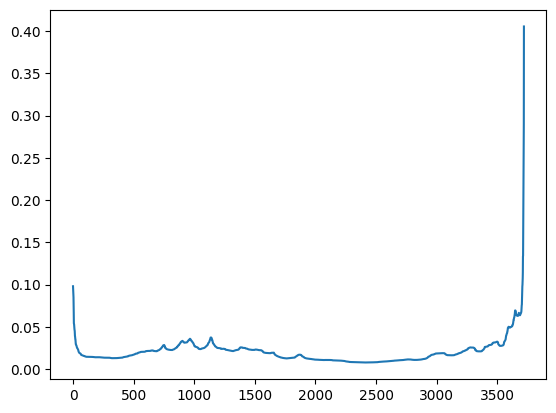

In [109]:
plt.plot(results)

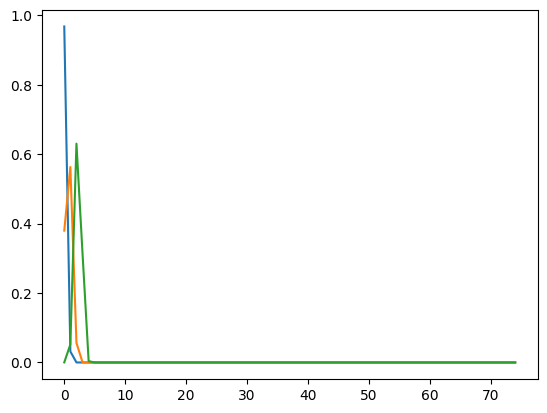

In [110]:
plt.plot(normalized[0])
plt.plot(normalized[20])

plt.plot(normalized[100])

In [111]:
def norm(x, max_value=1):
    """
    Normalize the input array to the range [0, max_value].
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x)) * max_value

In [112]:
res = rep1_trans[:, 0] / sum(rep1_trans[:, 0])

res, sum(res)

(array([9.68212173e-001, 3.17173963e-002, 7.04242163e-005, 6.41058556e-009,
        1.45720080e-014, 7.98191393e-022, 1.08276415e-030, 4.35670487e-041,
        4.50000492e-053, 1.07152055e-066, 5.82434296e-082, 7.78219532e-099,
        2.20771432e-117, 2.55056994e-137, 3.65689241e-159, 1.64779381e-182,
        2.34626989e-207, 8.27374380e-234, 4.89965208e-262, 1.04924934e-291,
        4.94065646e-323, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00

In [113]:
tresh = 0.002

mapped_warped_pseudotimes = []

for i in range(rep1_trans.shape[1]):
    res = rep1_trans[:, i] / sum(rep1_trans[:, i])

    warped_pseudotimes = d3.obs[res > tresh].pseudotime_warped.values
    contribution_amounts = res[res > tresh]

    result = np.average(warped_pseudotimes, weights=contribution_amounts)
    mapped_warped_pseudotimes.append(result)

mapped_warped_pseudotimes



[np.float64(0.00015445661264588828),
 np.float64(0.0002943686312686672),
 np.float64(0.0003548727391635674),
 np.float64(0.00048065304164590845),
 np.float64(0.0005145107200465026),
 np.float64(0.000945343629397194),
 np.float64(0.0010639509678243284),
 np.float64(0.0016347210204919781),
 np.float64(0.0016925444453956885),
 np.float64(0.001719782514663084),
 np.float64(0.001881186478143568),
 np.float64(0.002095876223705903),
 np.float64(0.0021105260454988505),
 np.float64(0.0021646513831191723),
 np.float64(0.002260713098394127),
 np.float64(0.002593906969749013),
 np.float64(0.002826512055283836),
 np.float64(0.002899785797699793),
 np.float64(0.0031475264614381584),
 np.float64(0.0032814348014535513),
 np.float64(0.003294497393335468),
 np.float64(0.0036701675202615728),
 np.float64(0.004136669955567584),
 np.float64(0.004202894090716265),
 np.float64(0.004225964766883571),
 np.float64(0.004239183802360025),
 np.float64(0.004400905517976276),
 np.float64(0.00444979878088443),
 np.fl

In [114]:
tresh = 0.002

mapped_warped_pseudotimes2 = []

for i in range(rep3_trans.shape[1]):
    res = rep3_trans[:, i] / sum(rep3_trans[:, i])

    warped_pseudotimes = d4.obs[res > tresh].pseudotime_warped.values
    contribution_amounts = res[res > tresh]

    result = np.average(warped_pseudotimes, weights=contribution_amounts)
    mapped_warped_pseudotimes2.append(result)

mapped_warped_pseudotimes2


[np.float64(0.003425055582949083),
 np.float64(0.0035572480357359297),
 np.float64(0.003996298775778439),
 np.float64(0.004172318893691104),
 np.float64(0.004307117500598294),
 np.float64(0.004338457760684686),
 np.float64(0.004608097069854002),
 np.float64(0.004938757388112074),
 np.float64(0.005083114179022073),
 np.float64(0.005248426267199866),
 np.float64(0.00528095065604552),
 np.float64(0.005296234731089489),
 np.float64(0.005546821791697843),
 np.float64(0.005706034056156723),
 np.float64(0.005714150372019463),
 np.float64(0.005804902180684938),
 np.float64(0.005861613394270408),
 np.float64(0.0062568251784611995),
 np.float64(0.006481631973338245),
 np.float64(0.0065696223879568895),
 np.float64(0.0067472497049741705),
 np.float64(0.006755779314335139),
 np.float64(0.006769831317405244),
 np.float64(0.006771957898045341),
 np.float64(0.006798990724321794),
 np.float64(0.007021035036300617),
 np.float64(0.007134067238355978),
 np.float64(0.0071883694916121815),
 np.float64(0.00

In [115]:
rep3_trans

array([[0.01657408, 0.01656019, 0.01634416, ..., 0.        , 0.        ,
        0.        ],
       [0.00538466, 0.00558622, 0.00619076, ..., 0.        , 0.        ,
        0.        ],
       [0.00103107, 0.00111064, 0.00138206, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02691084, 0.02360956,
        0.00718254],
       [0.        , 0.        , 0.        , ..., 0.08017413, 0.08009214,
        0.0527034 ],
       [0.        , 0.        , 0.        , ..., 0.13088282, 0.14887894,
        0.21190477]], shape=(150, 6934))

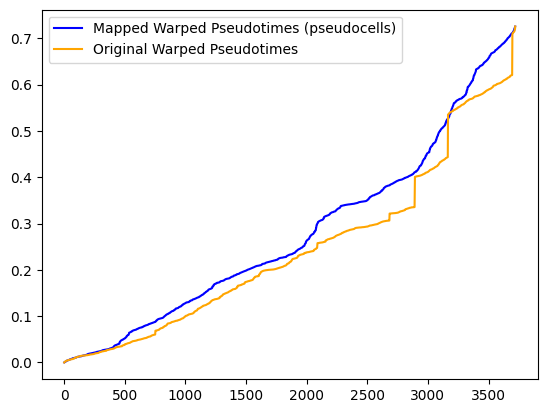

In [116]:
plt.plot(mapped_warped_pseudotimes, label="Mapped Warped Pseudotimes (pseudocells)", color = "blue")
plt.plot(rep1_mono.obs.pseudotime_warped.values, label="Original Warped Pseudotimes", color = "orange")
plt.legend()

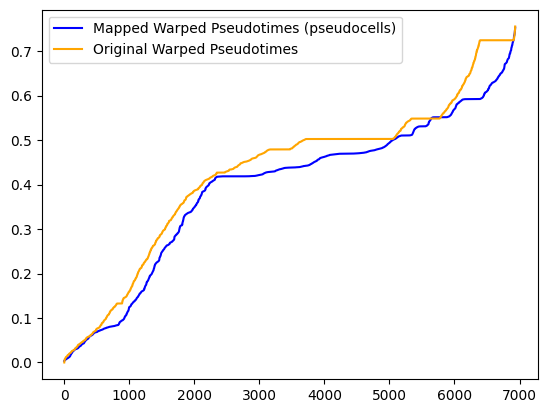

In [117]:
plt.plot(mapped_warped_pseudotimes2, label="Mapped Warped Pseudotimes (pseudocells)", color = "blue")
plt.plot(rep3_mono.obs.pseudotime_warped.values, label="Original Warped Pseudotimes", color = "orange")
plt.legend()

In [118]:
d3.obs.pseudotime_warped

pseudocell_0     0.000000
pseudocell_1     0.004869
pseudocell_2     0.009739
pseudocell_3     0.014608
pseudocell_4     0.019478
                   ...   
pseudocell_70    0.706068
pseudocell_71    0.710937
pseudocell_72    0.715807
pseudocell_73    0.720676
pseudocell_74    0.725546
Name: pseudotime_warped, Length: 75, dtype: float64

In [119]:
rep1_mono

AnnData object with n_obs × n_vars = 3721 × 2048
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono', 'avg_cost_free', 'avg_dist_free', 'pseudotime_warped'
    uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values', 'transition_matrix_100', 'transition_matrix_75'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'tsne'
    varm: 'pseudocells_100_Mono'

In [42]:
import pandas as pd

In [43]:
rep1_mono.varm["pseudocells_100_Mono"].T

array([[ 0.08056725,  0.02230468,  0.02601174, ..., -0.01290076,
        -0.04297491,  0.25948489],
       [ 0.08313364,  0.01815232,  0.03340107, ..., -0.0153929 ,
        -0.0213631 ,  0.26760534],
       [ 0.08248602,  0.01628117,  0.03595494, ..., -0.01710174,
        -0.01083063,  0.27060856],
       ...,
       [-0.13312276, -0.01490065,  0.04996939, ..., -0.04087883,
        -0.06487806,  0.32217695],
       [-0.21675841, -0.03730649,  0.05436226, ..., -0.02347491,
        -0.03116571,  0.40750609],
       [-0.34680979, -0.06158378, -0.00454219, ...,  0.01006569,
         0.02489993,  0.5079212 ]], shape=(100, 2082))

In [44]:
rep1_mono.uns["pseudocells_100_Mono_pseudotime"]

'removed'

In [45]:
d3 = ad.AnnData(X = rep1_mono.varm["pseudocells_100_Mono"].T, var = rep1_mono.var, obs = pd.DataFrame({"pseudotime": rep1_mono_pseudotimes}))
d4 = ad.AnnData(X = rep3_mono.varm["pseudocells_100_Mono"].T, var = rep3_mono.var, obs = pd.DataFrame({"pseudotime": rep3_mono_pseudotimes}))
d3, d4

(AnnData object with n_obs × n_vars = 100 × 2082
     obs: 'pseudotime',
 AnnData object with n_obs × n_vars = 100 × 2066
     obs: 'pseudotime')

In [46]:
all1 = ad.concat([rep1_mono, d3], axis=0, label = "type", keys = ["original", "pseudocells"])
all2 = ad.concat([rep3_mono, d4], axis=0, label = "type", keys = ["original", "pseudocells"])

/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [47]:
all1, all2

(AnnData object with n_obs × n_vars = 3821 × 2082
     obs: 'pseudotime', 'type',
 AnnData object with n_obs × n_vars = 7034 × 2066
     obs: 'pseudotime', 'type')

In [48]:
sc.pp.neighbors(all1)
sc.tl.umap(all1)


/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 2082 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


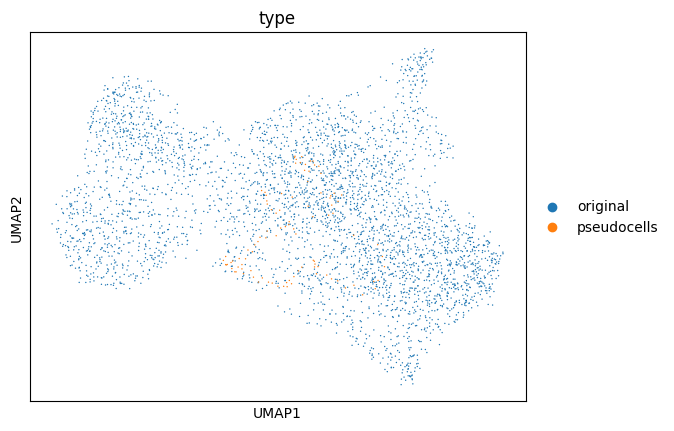

In [49]:
sc.pl.umap(all1, color = ["type"], size = 4)

In [50]:
rep1_mono

AnnData object with n_obs × n_vars = 3721 × 2082
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono'
    uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values', 'transition_matrix_100'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'tsne'
    varm: 'pseudocells_100_Mono'

In [51]:
rep1_mono_, rep1_mono_pseudocells, rep1_mono_pseudotimes = calc_pc(rep1_mono, 100, obsm_key="MAGIC_imputed_data")
# rep2_mono_, rep2_mono_pseudocells, rep2_mono_pseudotimes = calc_pc(rep2_mono, 1000)
rep3_mono_, rep3_mono_pseudocells, rep3_mono_pseudotimes = calc_pc(rep3_mono, 100, obsm_key="MAGIC_imputed_data")

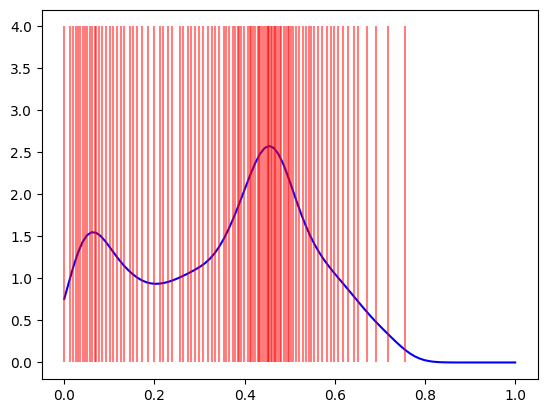

In [52]:
import scipy as sp
pseudotimes_kde_orig = sp.stats.gaussian_kde(rep1_mono.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(rep1_mono_pseudotimes.values(), 0, 4, color = "red", alpha=0.5)

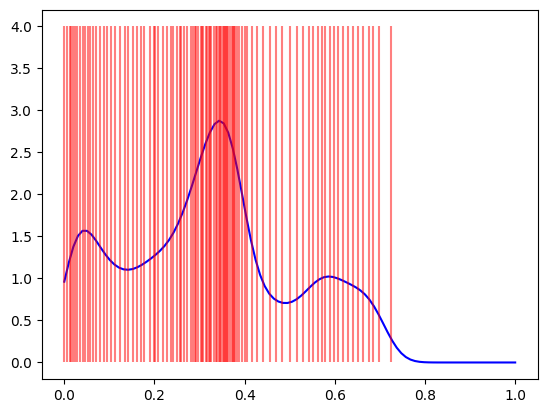

In [53]:
pseudotimes_kde_orig_3 = sp.stats.gaussian_kde(rep3_mono.obs["pseudotime"])
x_values3 = np.linspace(0, 1, 100)
y_values3 = pseudotimes_kde_orig_3(x_values3)
plt.plot(x_values3, y_values3, color = "blue")
plt.vlines(rep3_mono_pseudotimes.values(), 0, 4, color = "red", alpha=0.5)

In [54]:
d3 = ad.AnnData(X = rep1_mono_pseudocells, var = rep1_mono.var, obs = pd.DataFrame({"pseudotime": rep1_mono_pseudotimes}))
d4 = ad.AnnData(X = rep3_mono_pseudocells, var = rep3_mono.var, obs = pd.DataFrame({"pseudotime": rep3_mono_pseudotimes}))
d3, d4

ValueError: Observations annot. `var` must have as many rows as `X` has columns (14651), but has 2082 rows.

/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


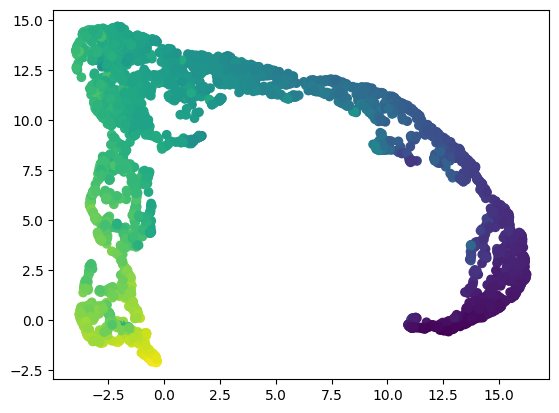

In [ ]:
import umap

trans = umap.UMAP().fit(rep1_mono.obsm['MAGIC_imputed_data'][:, :])
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c = rep1_mono.obs["pseudotime"])
plt.show()

In [ ]:
d3

AnnData object with n_obs × n_vars = 100 × 14651
    obs: 'pseudotime'

/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


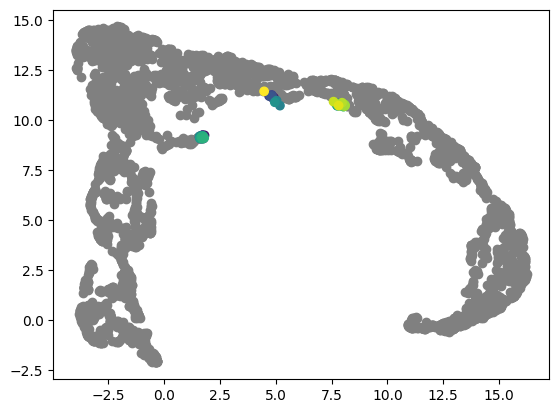

In [ ]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c ="grey")

test_emb = trans.transform(d3.X[:,:])
plt.scatter(test_emb[:, 0], test_emb[:,1], c = d3.obs["pseudotime"])

In [ ]:
d3.obs

,pseudotime
pseudocell_0,0.000000
pseudocell_1,0.013821
pseudocell_2,0.020223
pseudocell_3,0.025955
pseudocell_4,0.030599
...,...
pseudocell_95,0.651482
pseudocell_96,0.672179
pseudocell_97,0.690675
pseudocell_98,0.717621


In [ ]:
total_p, cost_p, distances_p = dtw(d3.X, d4.X)

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [ ]:
d3.X.shape, d4.X.shape

((100, 14651), (100, 14044))